<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/master/notebooks/actions_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Freeze torch version
!pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric scipy==1.8 deepchem

# Install gflownet lib
!pip install -e ./gflownet

Cloning into 'gflownet'...
remote: Enumerating objects: 1384, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1384 (delta 362), reused 337 (delta 312), pack-reused 902
Receiving objects: 100% (1384/1384), 13.53 MiB | 17.99 MiB/s, done.
Resolving deltas: 100% (768/768), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    F

In [2]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional

import matplotlib.pyplot as plt
import networkx as nx
import deepchem as dc

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
from gflownet.tasks.seh_frag import SEHFragTrainer

In [4]:
hps = {
    "log_dir": "./logs/debug_run_seh_frag_pb",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "overwrite_existing_exp": True,
    "num_training_steps": 500,
    "num_workers": 2,
    "opt": {
        "lr_decay": 20000,
    },
    "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
    "cond": {
        "temperature": {
            "sample_dist": "uniform",
            "dist_params": [0, 64.0],
        }
    },
}
if os.path.exists(hps["log_dir"]):
    if hps["overwrite_existing_exp"]:
        shutil.rmtree(hps["log_dir"])
    else:
        raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
os.makedirs(hps["log_dir"])

trial = SEHFragTrainer(hps)
trial.print_every = 100
# trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: cfe5a47e0638
pickle_mp_messages: false
git_hash: f4ee28e
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    la

In [ ]:
PATH = "./model"

In [ ]:
# torch.save(trial.model.state_dict(), PATH)

In [ ]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

In [ ]:
# Trajectories generation

n = 1000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen<n:

    pred = trial.algo.graph_sampler.sample_from_model(
    model,
    batch_size,
    trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
    "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

In [ ]:
# Inverse transformation of rewards
rew = [8*r for r in rew]

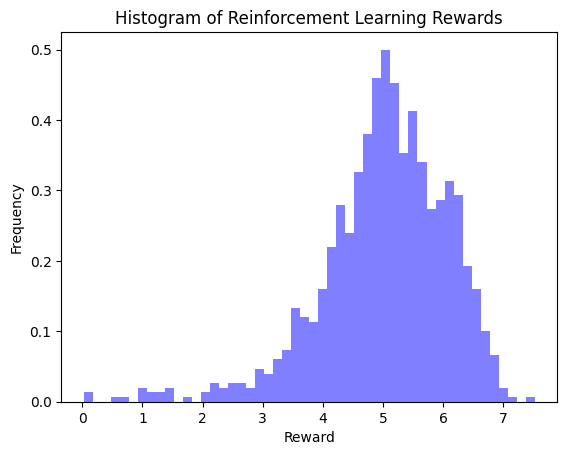

In [ ]:
# Create a histogram
plt.hist(rew, bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Reinforcement Learning Rewards')

# Show the plot
plt.show()

In [ ]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")

(<[0, 1, 2, 3], [(0, 1), (0, 3), (1, 2)], [12, 7, 65, 9]>, <GraphActionType.AddNode, 3, 4>)
Current graph: <[0, 1, 2, 3], [(0, 1), (0, 3), (1, 2)], [12, 7, 65, 9]>
Current action: <GraphActionType.AddNode, 3, 4>
Action source: 3
Action target: None
Action value: 4


C1CNCCN1
C1CCCCC1
c1ccccc1
C1CCNCC1
Next fragment added: C1=CNC=CC1


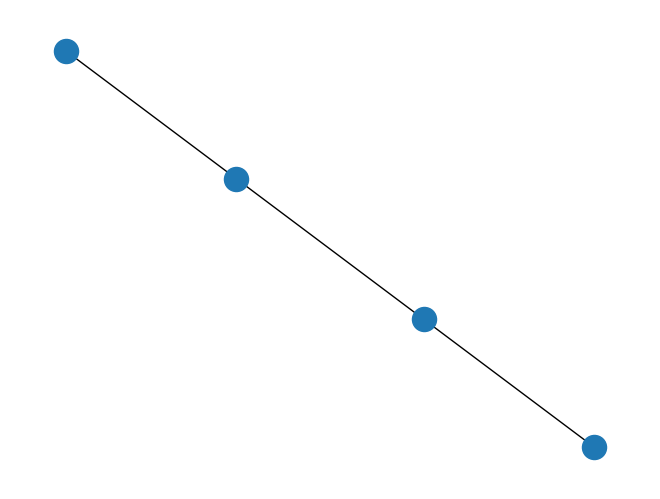

In [ ]:
# How does nodes translate to fragments?
g = traj[traj_id][state][0]
for i in g.nodes:
    mol = trial.ctx.frags_mol[g.nodes[i]["v"]]
    mol_smi = trial.ctx.frags_smi[g.nodes[i]["v"]]
    print(mol_smi)
print(f"Next fragment added: {trial.ctx.frags_smi[cur_action.value]}")
nx.draw(g)

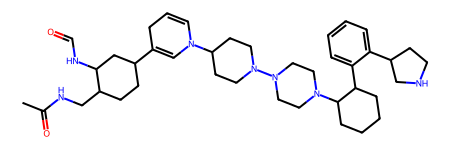

In [ ]:
# Output molecule
trial.ctx.graph_to_mol(traj[traj_id][-1][0])

### Trajectories to graphs and molecules features

In [ ]:
# Keep only graphs from trajectories
graphs = []

for t in traj:
    cur_act = []
    for step in t:
        cur_act.append(step[0])
    graphs.append(cur_act)

In [ ]:
def graph_to_mol(trial_ctx, g: Graph) -> Chem.Mol:
    # Modified to transform also not valid molecules
    """Convert a Graph to an RDKit molecule

    Parameters
    ----------
    g: Graph
        A Graph instance representing a fragment junction tree.

    Returns
    -------
    m: Chem.Mol
        The corresponding RDKit molecule
    """
    offsets = np.cumsum([0] + [trial_ctx.frags_numatm[g.nodes[i]["v"]] for i in g])
    mol = None
    for i in g.nodes:
        if mol is None:
            mol = trial_ctx.frags_mol[g.nodes[i]["v"]]
        else:
            mol = Chem.CombineMols(mol, trial_ctx.frags_mol[g.nodes[i]["v"]])

    mol = Chem.EditableMol(mol)
    bond_atoms = []
    for a, b in g.edges:
        afrag = g.nodes[a]["v"]
        bfrag = g.nodes[b]["v"]
        # if self.fail_on_missing_attr:
        #     assert "src_attach" in g.edges[(a, b)] and "dst_attach" in g.edges[(a, b)]
        u, v = (
            int(trial_ctx.frags_stems[afrag][g.edges[(a, b)].get("src_attach", 0)] + offsets[a]),
            int(trial_ctx.frags_stems[bfrag][g.edges[(a, b)].get("dst_attach", 0)] + offsets[b]),
        )
        bond_atoms += [u, v]
        mol.AddBond(u, v, Chem.BondType.SINGLE)
    mol = mol.GetMol()
    def _pop_H(atom):
        atom = mol.GetAtomWithIdx(atom)
        nh = atom.GetNumExplicitHs()
        if nh > 0:
            atom.SetNumExplicitHs(nh - 1)

    list(map(_pop_H, bond_atoms))
    Chem.SanitizeMol(mol)
    return mol

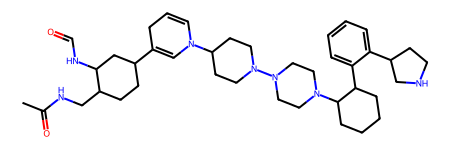

In [ ]:
graph_to_mol(trial.ctx, graphs[traj_id][-1])

In [ ]:
# Store mol representation on each trajectory step
# If mol is not valid at that step, previous valid is taken
mols = []
valid = []

for t in graphs:
    cur_traj = []
    cur_val = []
    last_val = None
    for g in t[1:]:
        try:
            cur_mol = graph_to_mol(trial.ctx, g)
            cur_traj.append(cur_mol)
            cur_val.append(True)
            last_val = cur_mol
        except:
            cur_val.append(False)
            cur_traj.append(last_val)
    mols.append(cur_traj)
    valid.append(cur_val)

### Check validity of molecules on given step

In [ ]:
df_valid = pd.DataFrame(valid)

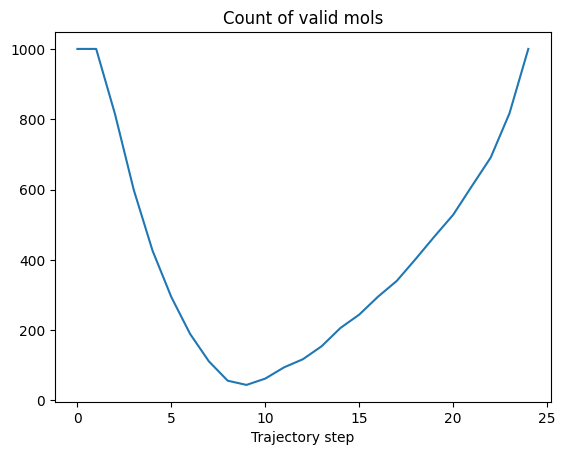

In [ ]:
plt.plot(range(len(df_valid.columns)), df_valid.sum())
plt.title("Count of valid mols")
plt.xlabel("Trajectory step")
plt.show()

### Basic graph properties

In [ ]:
# Here we can see what attributes are required for each node
graphs[0][-1].edges(data=True)

EdgeDataView([(0, 1, {'src_attach': 4, 'dst_attach': 1}), (0, 2, {'src_attach': 1, 'dst_attach': 5}), (0, 4, {'dst_attach': 0, 'src_attach': 3}), (1, 3, {'dst_attach': 1, 'src_attach': 0}), (3, 8, {'dst_attach': 3, 'src_attach': 2}), (4, 5, {'src_attach': 1, 'dst_attach': 1}), (5, 6, {'dst_attach': 1, 'src_attach': 0}), (6, 7, {'dst_attach': 0, 'src_attach': 0})])

In [ ]:
num_edges = []
num_nodes = []
valid_edges = []
for t in graphs:
    e = []
    n = []
    val_e = []
    for g in t:
        n.append(g.number_of_nodes())
        e.append(g.number_of_edges())
        e_cnt = 0
        for u, v, a in g.edges(data=True):
            if ('dst_attach' in list(a.keys())) & ('src_attach' in list(a.keys())):
                e_cnt += 1
        val_e.append(e_cnt)
    valid_edges.append(val_e)
    num_edges.append(e)
    num_nodes.append(n)

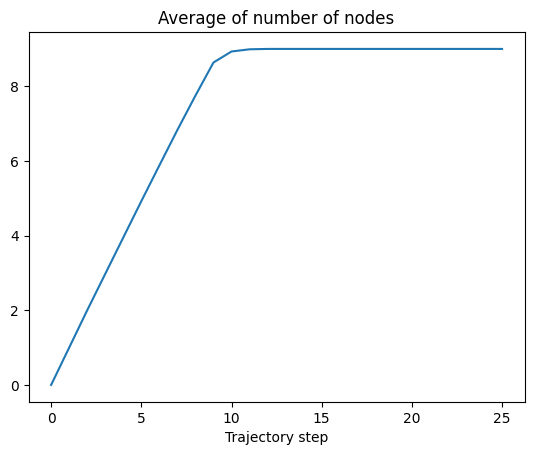

In [ ]:
df_nodes = pd.DataFrame(num_nodes)
plt.plot(range(len(df_nodes.columns)), df_nodes.mean())
plt.title("Average of number of nodes")
plt.xlabel("Trajectory step")
plt.show()

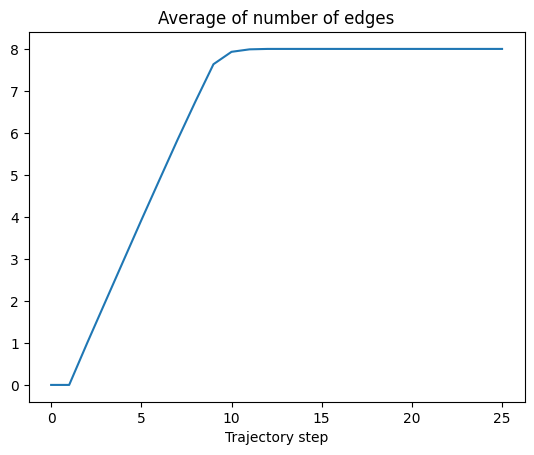

In [ ]:
df_edges = pd.DataFrame(num_edges)
plt.plot(range(len(df_edges.columns)), df_edges.mean())
plt.title("Average of number of edges")
plt.xlabel("Trajectory step")
plt.show()

In [ ]:
for id, t in enumerate(valid_edges):
    total_edges = t[-1]
    valid_edges[id] = [x/total_edges for x in t]

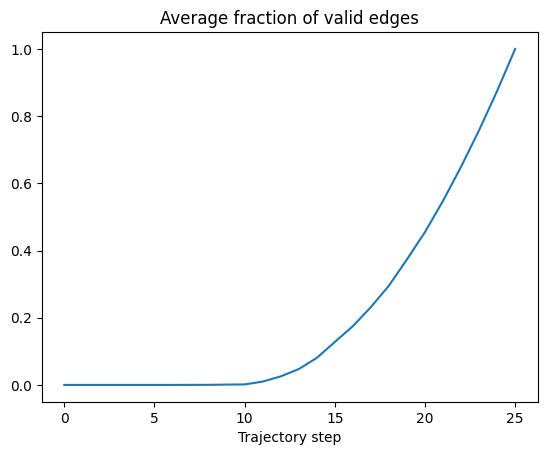

In [ ]:
df_val_edges = pd.DataFrame(valid_edges)
plt.plot(range(len(df_val_edges.columns)), df_val_edges.mean())
plt.title("Average fraction of valid edges")
plt.xlabel("Trajectory step")
plt.show()

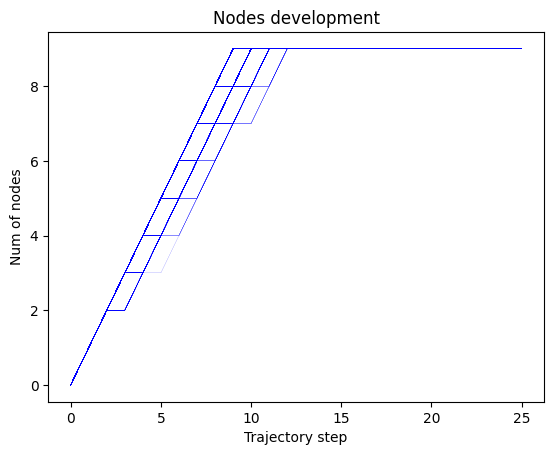

In [ ]:
for t in num_nodes:
    plt.plot(range(len(t)), t, color="blue", linewidth=0.1)
plt.title("Nodes development")
plt.xlabel("Trajectory step")
plt.ylabel("Num of nodes")
plt.show()

### Chemical features

In [ ]:
# Chem featurizer
feat = dc.feat.RDKitDescriptors()

In [ ]:
arr = feat.featurize(mols[traj_id])

In [ ]:
pd.DataFrame(arr, columns=feat.descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,3.222222,3.222222,1.138889,1.138889,0.402237,24.000000,86.138,76.058,86.084398,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.412136,3.412136,0.931343,0.931343,0.633179,29.000000,168.284,148.124,168.162649,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.480823,3.480823,0.334931,0.334931,0.860324,24.888889,244.382,220.190,244.193949,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Featurize data
num_actions = []
for m in mols:
    num_actions.append(feat.featurize(m).tolist())

In [ ]:
flat_X = []
flat_y = []
for id, t in enumerate(num_actions):
    actions = traj[id][1:]
    for idx, a in enumerate(t):
        flat_X.append(a)
        flat_y.append(actions[idx][1].action.cname)

In [ ]:
df_flat_ = pd.DataFrame(flat_X, columns=feat.descriptors)
df_flat_["target"] = flat_y
print(df_flat_.size)

5275000


In [ ]:
# Because of replication of mols for not valid steps there are many duplicates
# We drop them for the classificator experiments
df_flat = df_flat_.drop_duplicates()
print(df_flat.size)

1586720


In [ ]:
df_flat.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,1.500000,1.500000,1.500000,1.500000,0.422316,24.000000,84.162,72.066,84.093900,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node
1,4.358426,4.358426,0.787037,0.787037,0.625645,20.363636,167.277,154.173,167.076870,60.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,add_node
2,4.606982,4.606982,0.193958,0.193958,0.761827,19.058824,243.375,226.239,243.108171,88.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,add_node
5,4.606982,4.606982,0.193958,0.193958,0.761827,19.058824,243.375,226.239,243.108171,88.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,set_edge_attr
13,13.404283,13.404283,0.086897,-1.431138,0.077142,24.563636,773.989,730.645,773.293028,282.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,set_edge_attr


In [ ]:
df_flat["target"].value_counts()

set_edge_attr    4261
add_node         2259
stop             1000
Name: target, dtype: int64

In [ ]:
# df_flat.to_csv("featurized_mols_actions.csv")

### Action classifier

In [5]:
df_flat = pd.read_csv("/content/featurized_mols_actions.csv", index_col=0)

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [7]:
# Exclude stop action
df_flat = df_flat[df_flat.target != "stop"]

In [8]:
X, y = df_flat[[col for col in df_flat.columns if col != "target"]], df_flat["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
rf = RandomForestClassifier()

# Fit the random search model
rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
rf.score(X_test, y_test)

0.7422758100979653

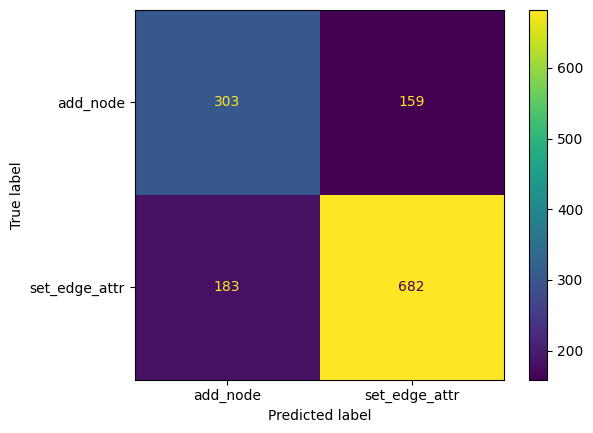

In [11]:
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

<Axes: >

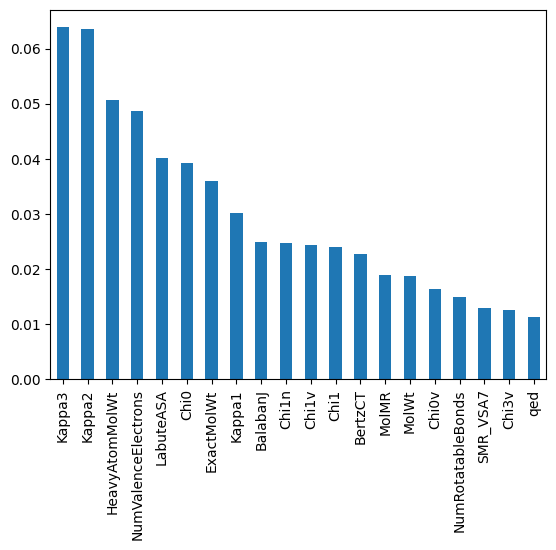

In [12]:
# Feat importance
sort_perm = np.argsort(rf.feature_importances_)
most_important = rf.feature_importances_[sort_perm][::-1]
most_important_names = rf.feature_names_in_[sort_perm][::-1]
forest_importances = pd.Series(most_important[:20], index=most_important_names[:20])
forest_importances.plot.bar()

In [13]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.8409947249434815

[Text(0.5, 0.8333333333333334, 'Kappa3 <= 5.202\ngini = 0.456\nsamples = 5307\nvalue = [1863, 3444]'), Text(0.25, 0.5, 'SMR_VSA7 <= 17.271\ngini = 0.422\nsamples = 2620\nvalue = [1828, 792]'), Text(0.125, 0.16666666666666666, 'gini = 0.313\nsamples = 1314\nvalue = [1059, 255]'), Text(0.375, 0.16666666666666666, 'gini = 0.484\nsamples = 1306\nvalue = [769, 537]'), Text(0.75, 0.5, 'BertzCT <= 705.879\ngini = 0.026\nsamples = 2687\nvalue = [35, 2652]'), Text(0.625, 0.16666666666666666, 'gini = 0.497\nsamples = 28\nvalue = [13, 15]'), Text(0.875, 0.16666666666666666, 'gini = 0.016\nsamples = 2659\nvalue = [22, 2637]')]


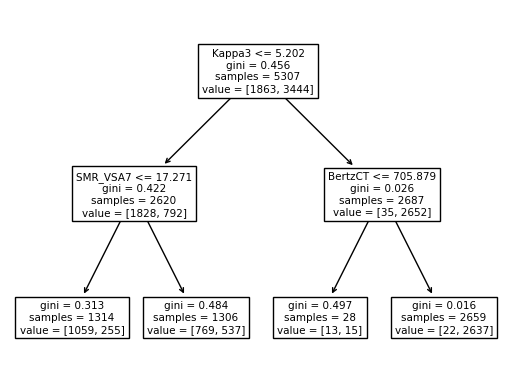

In [14]:
print(plot_tree(tree, feature_names=tree.feature_names_in_))

### Variable selection with LASSO

In [15]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [16]:
# parameters to be tested on GridSearchCV
lasso = Lasso(max_iter=10000, alpha=0.1)
lb = LabelBinarizer()
# GridSearchCV with model, params and folds.
lasso.fit(X_train, lb.fit_transform(y_train))

Lasso(alpha=0.1, max_iter=10000)

<Axes: >

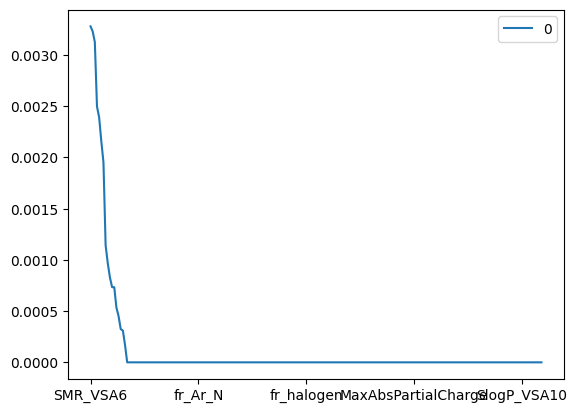

In [17]:
lasso_coef = np.abs(lasso.coef_)
df_coef = pd.DataFrame(lasso_coef, lasso.feature_names_in_).sort_values(by=0, ascending=False)
df_coef.plot()

In [19]:
selected = df_coef.index[df_coef.iloc[:, 0]>0].values
selected

array(['SMR_VSA6', 'SMR_VSA7', 'SMR_VSA4', 'MolWt', 'PEOE_VSA1',
       'SlogP_VSA2', 'PEOE_VSA6', 'EState_VSA5', 'SMR_VSA5',
       'EState_VSA4', 'TPSA', 'PEOE_VSA9', 'PEOE_VSA8', 'EState_VSA7',
       'EState_VSA8', 'BertzCT', 'VSA_EState2'], dtype=object)

In [20]:
rf_2 = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf_2, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train[selected], y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
rf_random.score(X_test[selected], y_test)

0.813112283345893